<div style="display: top; background-image:url('https://d1.awsstatic.com/SageMaker/SageMaker%20reInvent%202020/ImgHead_Mohave.3b1df33baa5f71b53237bfa6911fb3adc4902c0e.png');background-position: center ;background-repeat: no-repeat;background-size: 100%; padding-top:20px;">
<div style="color:#FFFFFF; text-align: top;padding-bottom: 25px; padding-left: 15px"><h1 style="font-weight: 900;">Project DAY 1 - SOLUTION</h1>
</div>
</div>
<br>

In this notebook, we will use KNN and Logistic Regression to predict the __isPositive__ field of an Amazon Product Review dataset. 

1. <a href="#1">Read the dataset</a> (Given) 
2. <a href="#2">Train a model</a> (Implement)
    * <a href="#21">Exploratory Data Analysis</a>
    * <a href="#22">Select features to build the model</a>
    * <a href="#23">Data processing</a>
    * <a href="#24">Model training</a>
3. <a href="#3">Make predictions on the test dataset</a> (Implement)
4. <a href="#4">Evaluate accuracy</a> (Given)

__Amazon Product Review Dataset__:

In this exercise, we are working with a product review dataset from Amazon. The raw data is available [here](https://nijianmo.github.io/amazon/index.html). You can find this dataset under __DATA/product-reviews__ in two variants (for regression or classification task): 
* _Amazon_Reviews_Regression.csv_ 
* _Amazon_Reviews_Classification.csv_

__Dataset schema:__ 

| __reviewText__      | __summary__ | __verified__     | __time__ | __log_votes__ | __isPositive__ |
| :---        |    :----:   |       :----:   |      :----:   |      :----:   |         ---: |
| Full text of the product review      | Summary text of the review       | Verified purchase? (True or False)  | UNIX timestamp for the review | Logarithm-adjusted votes log(1+votes)  | Positive review? (1 - yes or 0 - no) |

__isPositive__ - This is the field to predict.


In [1]:
# # Upgrade dependencies
# !pip install --upgrade pip
# !pip install --upgrade scikit-learn

In [2]:
# Import needed libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import shuffle

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    accuracy_score,
    f1_score,
)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

import warnings

warnings.filterwarnings("ignore")

%matplotlib inline

## 1. <a name="1">Read the datasets</a> (Given)
(<a href="#0">Go to top</a>)

Let's read the datasets into dataframes, using Pandas.

In [3]:
# Read in the dataset
df = pd.read_csv("../../DATA/product-reviews/Amazon_Reviews_Classification.csv")

# We split between train and test data
training_data, test_data = train_test_split(df, test_size=0.15, random_state=1)

print("The shape of the training dataset is:", training_data.shape)
print("The shape of the test dataset is:", test_data.shape)

The shape of the training dataset is: (59500, 6)
The shape of the test dataset is: (10500, 6)


## 2. <a name="2">Train a model</a> (Implement)
(<a href="#0">Go to top</a>)

 * <a href="#21">Exploratory Data Analysis</a>
 * <a href="#22">Select features to build the model</a>
 * <a href="#23">Data processing</a>
 * <a href="#24">Model training</a>

### 2.1 <a name="21">Exploratory Data Analysis</a> 
(<a href="#2">Go to Train a model</a>)

Look at the number of rows, columns and some simple statistics of the dataset; `.head()` and `.info()` can help with this.

In [4]:
training_data.head(2)

reviewText  \
28204  Every year I upgrade. Guess I could skip it a ...   
5875   I have used TurboTax for the past four or five...   

                                summary  verified        time  log_votes  \
28204  Just my annual renewal as always     False  1391299200        0.0   
5875                 Helpful As Always!      True  1362268800        0.0   

       isPositive  
28204         1.0  
5875          1.0

In [5]:
training_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59500 entries, 28204 to 5192
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   reviewText  59490 non-null  object 
 1   summary     59489 non-null  object 
 2   verified    59500 non-null  bool   
 3   time        59500 non-null  int64  
 4   log_votes   59500 non-null  float64
 5   isPositive  59500 non-null  float64
dtypes: bool(1), float64(2), int64(1), object(2)
memory usage: 2.8+ MB


#### Model features vs model target
For further analysis seperate the model features from the target based on data type and using the information in the data schema.

In [6]:
# Split model target and features
model_target = "isPositive"  # 0 & 1
model_features = training_data.columns.drop(model_target).tolist()

Create the list of features (based on type). To split out text features for example:
    
`text_features = training_data.select_dtypes(include='object').columns.tolist()
`



In [7]:
# Split model features between text and numerical features
text_features = training_data.select_dtypes(include="object").columns.tolist()
numerical_features = (
    training_data.select_dtypes(include=np.number).columns.drop(model_target).tolist()
)

Let's keep going with the EDA and plot histograms for all text features:

reviewText


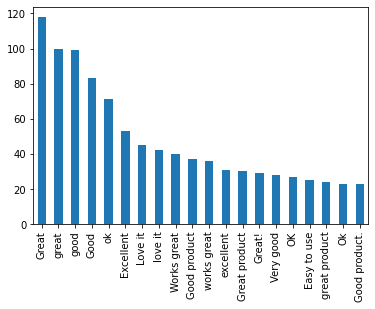

summary


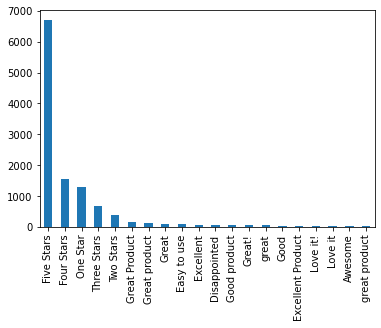

In [8]:
plt.figure(figsize=(6, 4))
for c in text_features:
    try:
        print(c)
        training_data[c].value_counts(sort=True)[
            :20
        ].plot.bar()  # only show 20 most frequent
        plt.show()
        plt.close()
    except:
        print("Could not plot feature %s" % c)
        pass

#### Target Distribution
Let's have a look at the number of instances of class 0 and 1 respectively by using `.value_counts()`.

<AxesSubplot:>

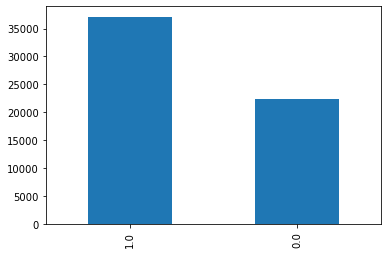

In [9]:
training_data[model_target].value_counts().plot.bar()

As the classes are imbalanced we want to upsample the underrepresented class.

In [10]:
print("Data set shape:", training_data.shape)

print("Class 0 samples in the data set:", sum(training_data[model_target] == 0))
print("Class 1 samples in the data set:", sum(training_data[model_target] == 1))

class_0_no = training_data[training_data[model_target] == 0]
class_1_no = training_data[training_data[model_target] == 1]

upsampled_class_0_no = class_0_no.sample(
    n=len(class_1_no), replace=True, random_state=42
)

training_data_upsampled = pd.concat([class_1_no, upsampled_class_0_no])
training_data_upsampled = shuffle(training_data_upsampled)

print("Data set shape:", training_data_upsampled.shape)

print(
    "Class 0 samples in the data set:", sum(training_data_upsampled[model_target] == 0)
)
print(
    "Class 1 samples in the data set:", sum(training_data_upsampled[model_target] == 1)
)

Data set shape: (59500, 6)
Class 0 samples in the data set: 22367
Class 1 samples in the data set: 37133
Data set shape: (74266, 6)
Class 0 samples in the data set: 37133
Class 1 samples in the data set: 37133


#### Upsampled Data
To check that the upsampling worked as expected, let's plot the distribution again.

<AxesSubplot:>

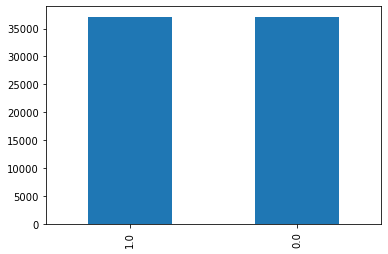

In [11]:
training_data_upsampled[model_target].value_counts().plot.bar()

### 2.2 <a name="22">Select features to build the model</a> 
(<a href="#2">Go to Train a model</a>)

Suggestion to use numerical features only (if you want to use categorical or text features, make sure to use [OneHotEncoder](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html) - models only understand numerical columns!).

Notice from EDA step that `time` is almost always unique and drop it from the features.

In [12]:
training_data_upsampled.drop(columns=["time"], inplace=True)

In [13]:
# Also make sure to remove it from the feature list
numerical_features.remove("time")
model_features.remove("time")

### 2.3 <a name="23">Data Processing</a> 
(<a href="#2">Go to Train a model</a>)


Try different scalers and imputers.

In [14]:
# Initilizing transformers and model
imputer = SimpleImputer(strategy="mean")
scaler = StandardScaler()

# Applying transformers
training_data_upsampled[numerical_features] = imputer.fit_transform(
    training_data_upsampled[numerical_features]
)
training_data_upsampled[numerical_features] = scaler.fit_transform(
    training_data_upsampled[numerical_features]
)

### 2.4 <a name="24">Model training/fitting</a> 
(<a href="#2">Go to Train a model</a>)

Suggestion to use:

`X_train = training_data[numerical_features]`   
`y_train = training_data[model_target]`

or if upsampled:

`X_train = training_data_upsampled[numerical_features]`   
`y_train = training_data_upsampled[model_target]`

In [15]:
X_train = training_data_upsampled[numerical_features]
y_train = training_data_upsampled[model_target]

# Trying different values of K in an automated way
K_values = [1, 2, 3, 4, 5, 6]

K_best = 0.0
train_score_best = 0.0
for K in K_values:
    classifier = KNeighborsClassifier(n_neighbors=K)
    classifier.fit(X_train, y_train)
    train_predictions = classifier.predict(X_train)
    train_acc = accuracy_score(y_train, train_predictions)
    print("K=%d, Train accuracy: %f" % (K, train_acc))
    if train_acc > train_score_best:
        K_best = K
        train_score_best = train_acc

print("K_best=%d, Best train accuracy: %f" % (K_best, train_score_best))

K=1, Train accuracy: 0.560593
K=2, Train accuracy: 0.602698
K=3, Train accuracy: 0.582043
K=4, Train accuracy: 0.602618
K=5, Train accuracy: 0.600625
K=6, Train accuracy: 0.499098
K_best=2, Best train accuracy: 0.602698


In [16]:
# Could try out different paramters, e.g. metric = 'manhattan'
classifier = KNeighborsClassifier(n_neighbors=K_best, metric="euclidean")
classifier.fit(X_train, y_train)

KNeighborsClassifier(metric='euclidean', n_neighbors=2)

## 3. <a name="3">Make predictions on the test dataset</a> (Implement)
(<a href="#0">Go to top</a>)

Use the test set to make predictions with the trained model. *Beware*: In the model evaluation code snippet, the model is called `classifier`; ensure to amend this as per model name used.

In [17]:
# Make sure to also apply transformer to test data
X_test = imputer.transform(test_data[numerical_features])
y_test = test_data[model_target]

# Use the fitted model to make predictions on the test dataset
test_predictions = classifier.predict(X_test)

## 4. <a name="4">Evaluate accuracy</a> (Given)
(<a href="#0">Go to top</a>)

Use the Sklearn in-built classification report to evaluate model accuracy on training and test data.

In [18]:
# Use the fitted model to make predictions on the train dataset
train_predictions = classifier.predict(X_train)

print("Model performance on the train set:")
print(confusion_matrix(y_train, train_predictions))
print(classification_report(y_train, train_predictions))
print("Train accuracy:", accuracy_score(y_train, train_predictions))

Model performance on the train set:
[[14920 22213]
 [ 7293 29840]]
              precision    recall  f1-score   support

         0.0       0.67      0.40      0.50     37133
         1.0       0.57      0.80      0.67     37133

    accuracy                           0.60     74266
   macro avg       0.62      0.60      0.59     74266
weighted avg       0.62      0.60      0.59     74266

Train accuracy: 0.602698408423774


In [19]:
print("Model performance on the test set:")
print(confusion_matrix(y_test, test_predictions))
print(classification_report(y_test, test_predictions))
print("Test accuracy:", accuracy_score(y_test, test_predictions))

Model performance on the test set:
[[3454  487]
 [6129  430]]
              precision    recall  f1-score   support

         0.0       0.36      0.88      0.51      3941
         1.0       0.47      0.07      0.12      6559

    accuracy                           0.37     10500
   macro avg       0.41      0.47      0.31     10500
weighted avg       0.43      0.37      0.26     10500

Test accuracy: 0.3699047619047619


Notice that test accuracy is worse than a coin flip. Clearly we need more features or a different model.

### Alternative model choice: Logistic Regression

Highest Accuracy on Test: 0.6565714285714286 , Threshold for the highest Accuracy: 0.38


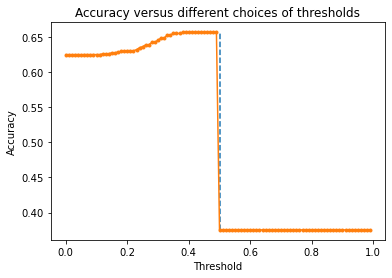

In [20]:
# Load a Logistic Regression classifier
classifier = LogisticRegression()
# Train the classifier
classifier.fit(X_train, y_train)

# Calculate the accuracy using different values for the classification threshold,
# and pick the threshold that resulted in the highest accuracy.
highest_accuracy = 0
threshold_highest_accuracy = 0

thresholds = np.arange(0, 1, 0.01)  # Trying different boundaries
scores = []
for t in thresholds:
    # set threshold to 't' instead of 0.5
    y_test_other = (classifier.predict_proba(X_test)[:, 1] >= t).astype(float)
    score = accuracy_score(y_test, y_test_other)
    scores.append(score)
    if score > highest_accuracy:
        highest_accuracy = score
        threshold_highest_accuracy = t
print(
    "Highest Accuracy on Test:",
    highest_accuracy,
    ", Threshold for the highest Accuracy:",
    threshold_highest_accuracy,
)

# Let's plot the accuracy versus different choices of thresholds
plt.plot([0.5, 0.5], [np.min(scores), np.max(scores)], linestyle="--")
plt.plot(thresholds, scores, marker=".")
plt.title("Accuracy versus different choices of thresholds")
plt.xlabel("Threshold")
plt.ylabel("Accuracy")
plt.show()

### Regularization

Regularization is a technique used for reducing the number of features the model uses by adding an additional penalty term in the error function. It can help make the model simpler and generalize better to unseen data.

There exist different regularization techniques and we will explore 2 of those in the sections below:

#### Ridge (L2 regularization)
Let's now fit __LogisticRegression__ from Sklearn library with the so-called Ridge penalty term, and check how many model weights remain after the regularization is applied.

Find more details on __Ridge__ [here](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html).

To improve the performance of a LinearRegression model, __Ridge__ is tuning model complexity by adding a $L_2$ penalty score for complexity to the model cost function:

$$\text{C}_{\text{regularized}}(\textbf{w}) = \text{C}(\textbf{w}) +  {alpha}∗||\textbf{w}||_2^2$$

where $\textbf{w}$ is the model weights vector, and $||\textbf{w}||_2^2 = \sum \textbf{w}_i^2$.

The strength of the regularization is controlled by the regularizer parameter, alpha: smaller value of $alpha$, weaker regularization; larger value of $alpha$, stronger regularization. 


In [21]:
classifier = LogisticRegression(penalty="l2")

#### LASSO ( L1 regularization)
Let's also fit __LogisticRegression__ with Lasso penalty from Sklearn.

Find more details on __Lasso__ [here](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html).

__Lasso__ is tuning model complexity by adding a $L_1$ penalty score for complexity to the model cost function:

$$\text{C}_{\text{regularized}}(\textbf{w}) = \text{C}(\textbf{w}) +  alpha∗||\textbf{w}||_1$$

where $\textbf{w}$ is the model weights vector, and $||\textbf{w}||_1 = \sum |\textbf{w}_i|$. 

Again, the strength of the regularization is controlled by the regularizer parameter, $alpha$. Due to the geometry of $L_1$ norm, with __Lasso__, some of the weights will shrink all the way to 0, leading to sparsity - some of the features are not contributing to the model afterall!

In [22]:
classifier = LogisticRegression(penalty="l1")